In [20]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim

## Punto 1: Simulación pelota rebotando

In [21]:
class Particle():
    
    def __init__(self, x0, v0, a0, t, m, radio, Id):   
                                                        
        self.dt = t[1] - t[0] 
        self.r = x0     
        self.v = v0  
        self.a = a0  
        
        self.rVector = np.zeros( (len(t),len(x0)) )    
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        self.m = m
        self.radio = radio
        self.Id = Id
        
    def Evolution(self,i):         
        
        self.setPosition(i,self.r)
        self.setVelocity(i,self.v)
        
        #Ecuaciones diferenciales según método de Euler
        
        self.r += self.dt*self.v     
        self.v += self.dt*self.a
    
    def CheckWallLimits(self, limits, dim=2):
        
        for i in range(dim):       #Se multiplica por 0.9 en cada condición para garantizar la pérdida de energía
            
            if self.r[i] + self.radio > limits[i]:
                
                self.v[i] = - 0.9*self.v[i]
            
            if self.r[i] - self.radio < - limits[i]:
                
                self.v[i] = - 0.9*self.v[i]
                
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        self.RvVector = np.array([self.vVector[0]]) #Se agrega el vector de velocidad reducido para graficar mejor
        
        for i in range(1,len(self.rVector)):
            
            if i%factor == 0:
                
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
                
    #Setters: Permite fijar los atributos, son métodos que no deberían retonar
    
    def setPosition(self, i, r):
        
        self.rVector[i] = r
        
    def setVelocity(self, i, v):
        self.vVector[i] = v
        
    #Getters: Ver los valores de los atributos, son métodos que normalmente retornan algo
    
    def GetR(self):
        
        return self.radio
    
    def GetPositionVector(self):
        
        return self.rVector
    
    def GetRPositionVector(self):
        
        return self.RrVector
    
    def GetAcelerationVector(self):
        
        return self.aVector
        
    def GetRVelocityVector(self):    #Se crea un método para obtener el vector velocidad reducido
        
        return self.RvVector
    
    def GetVelocityVector(self):
        
        return self.vVector

In [22]:
#Discretización 

dt = 0.01
tmax = 30
t = np.arange(0, tmax + dt, dt) 

In [23]:
def GetParticles(NParticles, Limit, Velo, Dim = 2, dt = 0.1):      #Genera las partículas
    
    Particles_ = []
    
    for i in range(NParticles):
        
        #Asegura las condiciones iniciales
        
        x0 = np.array([-15.,5.])
        v0 = np.array([1.,0.]) 
        a0 = np.array([0.,-9.8])
        
        p = Particle(x0,v0,a0,t,1.,1.,i)      #Radio = 1, masa = 1
        
        Particles_.append(p)
        
    return Particles_     

In [24]:
limits = np.array([20.,20.])     #Caja ajustada a 20x20

def RunSimulation(t, Velo, NParticles):
    
    Particles = GetParticles(NParticles,limits[0],Velo,dt=dt)
    
    for it in tqdm(range(len(t))):  
        
        for i in range(len(Particles)):
            
            Particles[i].CheckWallLimits(limits)
            Particles[i].Evolution(it)
            
    return Particles

In [25]:
Particles = RunSimulation(t,NParticles=1,Velo=50)

100%|███████████████████████████████████████████████████████████████████████████| 3001/3001 [00:00<00:00, 72099.36it/s]


In [26]:
#Reducción del tiempo

def ReduceTime(t,factor):
    
    for p in Particles:
        
        p.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        
        if i%factor == 0:
            
            Newt.append(t[i])
            
    return np.array(Newt)

In [27]:
redt = ReduceTime(t,10)      #Reducción en 10

Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\Usuario\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\Usuario\anaconda3\lib\threading.py", line 1254, in run
    self.function(*self.args, **self.kwargs)
TypeError: 'NoneType' object is not callable


## Animación

<IPython.core.display.Javascript object>


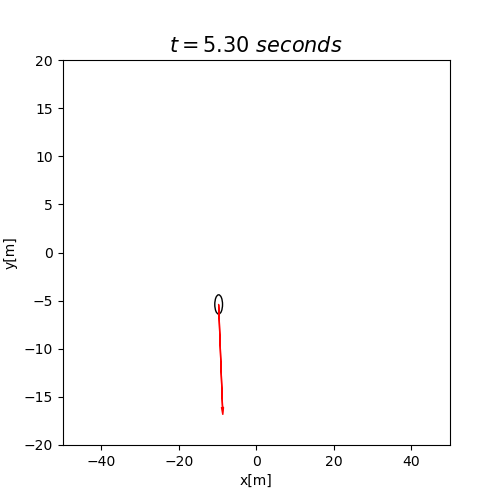

In [28]:
#Animaciones

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

#Función de inicio

def init():  
    
    ax.set_xlim(-limits[0],limits[0])
    ax.set_ylim(-limits[1],limits[1])
    
#Función de actualización

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15) 
    
    for p in Particles:
        
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        
        vx = p.GetRVelocityVector()[i,0]     #Se agrega el vector velocidad reducido
        vy = p.GetRVelocityVector()[i,1]
        
        circle = plt.Circle((x,y), p.GetR(), color='k', fill = False)
        plot = ax.add_patch(circle)
        plot = ax.arrow(x, y, vx, vy, color='r', head_width=0.5)
        ax.set_xlabel('x[m]')
        ax.set_ylabel('y[m]')
        
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)
plt.show()

Podemos ver que al rededor de los 19s la simulación presenta un fallo debido a la acumulación de errores proveniente del método de Euler. Esto se podría mejorar usando un paso temporal de 0.001s.

## Gráfica energía cinética

In [29]:
def KEnergy(p,t):
    
    v = p.GetVelocityVector()   #Obtiene el vector velocidad
    Energy = []  #Crea el contenedor de las energías cinéticas
    
    for i in v: 
        
        e = 1/2 * 1 * np.sqrt(i[0]**2 + i[1]**2)      #Calcula la energía cinética calculando la norma de la velocidad
        
        Energy.append(e)         #Agrega las energías al contenedor
        
    fig = plt.figure()           #Grafica
    plt.xlabel('Time[s]')
    plt.ylabel('Kinetic Energy[J]')
    #plt.savefig('dt={:2f}.png'.format(dt))
    
    return plt.plot(t,np.array(Energy))

<IPython.core.display.Javascript object>


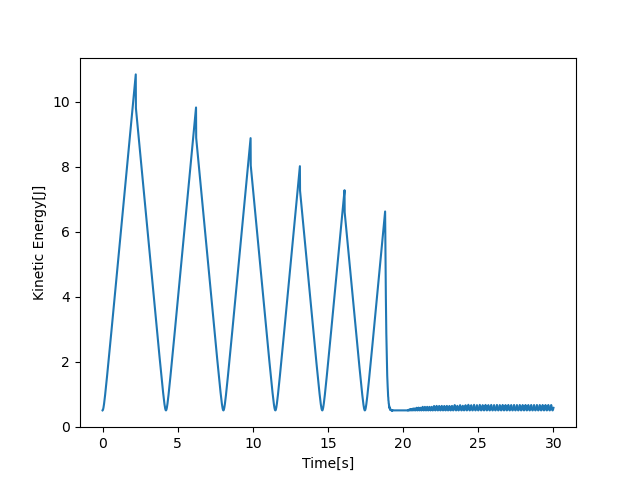

In [30]:
KEnergy(Particles[0],t)   #Imprime gráfica

El fallo en la simulación se refleja también en la curva obtenida para la energía cinética.

## Estimación tiempo

Discretización con paso de tiempo menor para obtner una mejor simulación, intervalo de tiempo más largo para estimar el tiempo de parada de la partícula y límites expandidos en x para que la partícula tenga más espacio para detenerse.

In [41]:
dt = 0.001
tmax = 45.5
t = np.arange(0, tmax + dt, dt) 

limits = np.array([50.,20.])     #Caja ajustada a 50x50

Particles = RunSimulation(t,NParticles=1,Velo=50)

redt = ReduceTime(t,100)      #Reducción en 10

100%|█████████████████████████████████████████████████████████████████████████| 45501/45501 [00:00<00:00, 85214.08it/s]


<IPython.core.display.Javascript object>


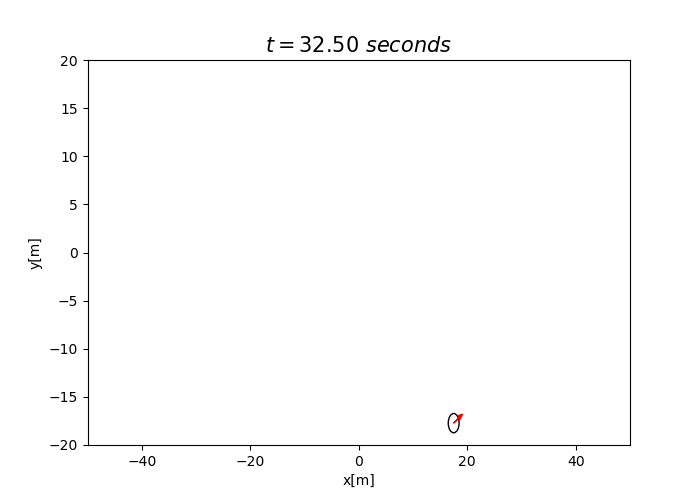

In [42]:
#Animaciones

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)

#Función de inicio

def init():  
    
    ax.set_xlim(-limits[0],limits[0])
    ax.set_ylim(-limits[1],limits[1])
    
#Función de actualización

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15) 
    
    for p in Particles:
        
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        
        vx = p.GetRVelocityVector()[i,0]     #Se agrega el vector velocidad reducido
        vy = p.GetRVelocityVector()[i,1]
        
        circle = plt.Circle((x,y), p.GetR(), color='k', fill = False)
        plot = ax.add_patch(circle)
        plot = ax.arrow(x, y, vx, vy, color='r', head_width=0.5)
        ax.set_xlabel('x[m]')
        ax.set_ylabel('y[m]')
        
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)
plt.show()

Teniendo en cuenta la simulación, se estima la detención entre 43s y 45s

<IPython.core.display.Javascript object>


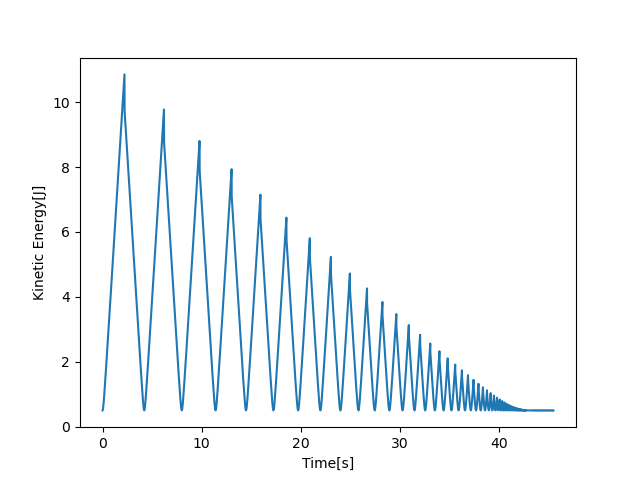

In [43]:
KEnergy(Particles[0],t) #Grafica de energía cinética

Con la gráfica se confirma dicha estimación y se establece un intervalo menor, entre 44.5 y 45

In [59]:
v = Particles[0].GetVelocityVector()

contador = 0 

for i in v: 
    
    contador +=1.
    
    velo = np.sqrt(i[0]**2+i[1]**2)
    
    if np.sqrt(i[0]**2+i[1]**2) < 1.000000000000009 and contador != 1: 
        
        print(contador*dt)
        break

44.994


Con el método anterior se calcula la magnitud de la velocidad y se establece un valor mínimo a partir del cual se considera que la pelota se encuentra quieta. Este valor mínimo se encuentra en 44.99s por lo que se considera este como el tiempo que tardará en detenerse la partícula.

Punto 2 -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [60]:
class Particle():
    
    def __init__(self, x0, v0, a0, t, m, radio, Id):   #Se trata del constructor de clase ''cómo construir el objeto''
                                                        #Siempre lleva el self porque hace referencia al objeto en creación
        self.dt = t[1] - t[0] #Paso del tiempo, es siempre constante
        self.r = x0     #Inicializar atributos
        self.v = v0  
        self.a = a0  
        
        self.rVector = np.zeros( (len(t),len(x0)) )    #Inicializar una matriz
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        self.m = m
        self.radio = radio
        self.Id = Id
        
    def Evolution(self,i):         #Ya es un método de la clase, con el self toma todo lo relacionado con el objeto
        
        self.setPosition(i,self.r)
        self.setVelocity(i,self.v)
        
        #Ecuaciones diferenciales según método de Euler
        
        self.r += self.dt*self.v     
        self.v += self.dt*self.a
    
    def CheckWallLimits(self, limits, dim=3):
        
        for i in range(dim):
            
            if self.r[i] + self.radio > limits[i]:
                
                self.v[i] = - self.v[i]
            
            if self.r[i] - self.radio < - limits[i]:
                
                self.v[i] = - self.v[i]
                
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
                
        for i in range(1,len(self.rVector)):
            
            if i%factor == 0:
                
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
    #Setters: Permite fijar los atributos, son métodos que no deberían retonar
    
    def setPosition(self, i, r):
        
        self.rVector[i] = r
        
    def setVelocity(self, i, v):
        self.vVector[i] = v
        
    #Getters: Ver los valores de los atributos, son métodos que normalmente retornan algo
    
    def GetR(self):
        
        return self.radio
    
    def GetPositionVector(self):
        
        return self.rVector
    
    def GetRPositionVector(self):
        
        return self.RrVector
        
    def GetVelocityVector(self):
        
        return self.vVector

In [61]:
#Discretización

dt = 0.001
tmax = 5
t = np.arange(0, tmax + dt, dt) 

In [62]:
def GetParticles(NParticles, Limit, Velo, Dim = 3, dt = 0.1):      #Genera las partículas
    
    Particles_ = []
    
    for i in range(NParticles):
        
        x0 = np.random.uniform(-Limit+1.0, Limit-1.0, size=Dim) #genera posiciones aleatorias de la dimensión especificada
        v0 = np.random.uniform(-Velo, Velo, size=Dim) #x0 Tienen una tolerancia que en realidad debería ser el radio de la partícula
        a0 = np.zeros(Dim)
        
        p = Particle(x0,v0,a0,t,1.,.2,i)
        
        Particles_.append(p)
        
    return Particles_     

In [68]:
limits = np.array([10.,10.,10.])

def RunSimulation(t, NParticles=100, Velo=6):
    
    Particles = GetParticles(NParticles,limits[0],Velo=Velo,dt=dt)
    
    for it in tqdm(range(len(t))):     
        
        for i in range(len(Particles)):
            
            Particles[i].CheckWallLimits(limits)
            Particles[i].Evolution(it)
            
    return Particles

In [69]:
Particles = RunSimulation(t,NParticles=100,Velo=20)

100%|█████████████████████████████████████████████████████████████████████████████| 5001/5001 [00:06<00:00, 793.91it/s]


In [70]:
def ReduceTime(t,factor):
    
    for p in Particles:
        
        p.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        
        if i%factor == 0:
            
            Newt.append(t[i])
            
    return np.array(Newt)

In [71]:
redt = ReduceTime(t,10)

In [73]:
#Para realizar animaciones

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')

#Función de inicio

def init():  #Ajusta la escala de los ejes
    
    ax.set_xlim(-11,11)
    ax.set_ylim(-11,11)
    ax.set_zlim(-11,11)
    
#Función de actualización

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15) #Ubica el título
    ax.set_xlabel('x[m]')    #Coloca el título a los ejes
    ax.set_ylabel('y[m]')
    ax.set_zlabel('z[m]')
    
    for p in Particles:
        
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        z = p.GetRPositionVector()[i,2]
        
        #circle = plt.Circle((x,y), p.GetR(), color='k', fill = True)
        plot = ax.scatter(x,y,z, color='black')
        
        #plot = ax.arrow(x, y, vx, vy, color='r', head_width=0.5)    #Flecha de velocidad
        
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

<IPython.core.display.Javascript object>